In [1]:
import polars as pl
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
df = pl.scan_parquet("../../data/edges")
df_w = pl.scan_parquet("../../data/wordcounts")
df_t = pl.scan_parquet("../../data/topics")
df_s = pl.scan_parquet("../../data/stances")
df = df.join(df_t.select("position", "topics"), on="position", how="left")
df = df.join(df_s.select("pos", "parsed_stance"), left_on="position",right_on="pos", how="left")
df = df.with_columns(pl.col("Date").str.to_date())
df = df.sort("Date", descending=False)
df = df.filter(pl.col("Party_orientation") != "-")

In [3]:
# Extract topic
df = df.filter(pl.col("topics").is_not_null())

def max_key_from_json(s):
    try:
        d = json.loads(s)
        return max(d, key=d.get)
    except Exception as e:
        return str(e)

df = df.with_columns([
    pl.col("topics")
    .str.replace_all("'", '"')   
    .map_elements(max_key_from_json, return_dtype=pl.String)
    .str.replace(r"[0-9]{3} \- ", "")
    .str.replace(r"\:.*", "")
    .alias("topics_e")
])

In [4]:
df = df.with_columns(
    pl.col("parsed_stance")
    .replace({"NEGATIVE": -1, "NEUTRAL": 0, "POSITIVE": 1,"": None})
    .cast(pl.Int16).alias("sentiment")
)

In [12]:
#df = df.filter((pl.col("entity") == "europe") | (pl.col("entity") == "eu"))
df = df.filter((pl.col("target_country") == "RU"))

df_fr = df.filter(pl.col("source_country") == "FR")
df_hu = df.filter(pl.col("source_country") == "HU")
df_nordics = df.filter(pl.col("source_country").is_in(["NO","DK","FI","SE"]))

In [6]:
def generate_wordcloud(df_wc, title, year, end_year = None):
#group by year as well as topic, calculate count and average sentiment
    df_wc_f = df_wc.group_by_dynamic("Date", every="1y", group_by=["topics_e"]).agg(
        pl.col("sentiment").mean().alias("avg_sentiment"),
        pl.len().alias("len")
    ).sort("len").drop_nulls()

#set year
    if end_year == None:
        df_wc_f = df_wc_f.filter(pl.col("Date") == datetime.datetime(year,1,1))
    else:
        df_wc_f = df_wc_f.filter(pl.col("Date").is_between(datetime.datetime(year, 12, 1), datetime.datetime(end_year, 12, 1)))
#create dict with word frequencies
    df_collected = df_wc_f.collect()
    keys = df_collected.get_column("topics_e").to_list()
    vals = df_collected.get_column("len").to_list()
    vals_sent = df_collected.get_column("avg_sentiment").to_list()

    freq_dict = dict(sorted(zip(keys, vals), key=lambda x: -x[1]))
    sent_dict = dict(zip(keys, vals_sent))

# custom color function
    def colorfs(word, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
        color = plt.get_cmap("coolwarm")((((sent_dict[word]*-1) + 1) / 2))
        rgb = tuple(int(255 * c) for c in color[:3])
        return '#{:02x}{:02x}{:02x}'.format(*rgb)
#make word cloud
    w = WordCloud(width=1920, height=1080,background_color="white",collocations=False, color_func=colorfs)
    w.generate_from_frequencies(freq_dict)
    plt.imshow(w, interpolation='nearest', aspect='auto')
    plt.title(title,fontsize=10)
    plt.axis("off")
    plt.show()
    

In [7]:
def orientation_split(df_a):
    df_right = df_a.filter((pl.col("Party_orientation").str.contains("[Rr]ight")))
    df_left = df_a.filter((pl.col("Party_orientation").str.contains("[Ll]eft")))
    df_center = df_a.filter(pl.col("Party_orientation").str.contains("[cC]entre"))
    return df_right, df_center, df_left

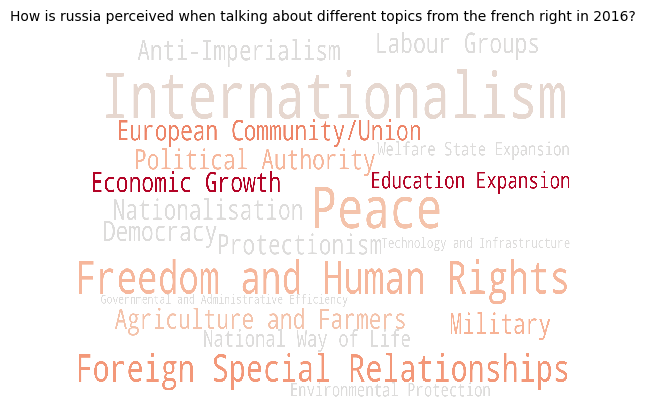

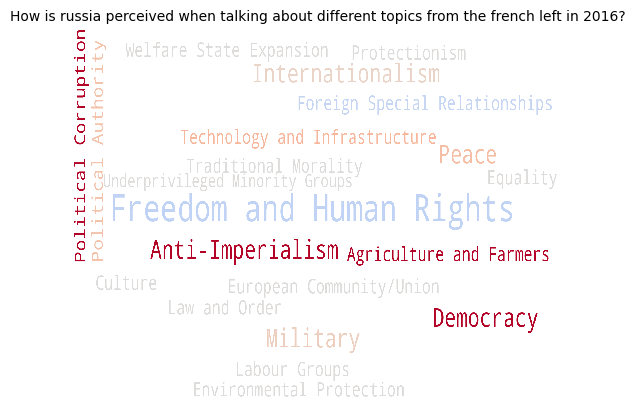

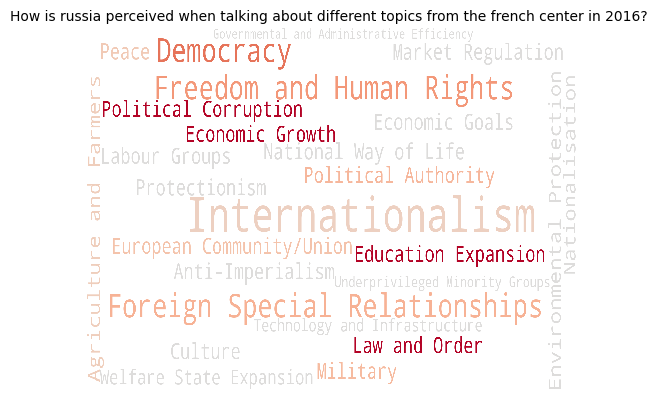

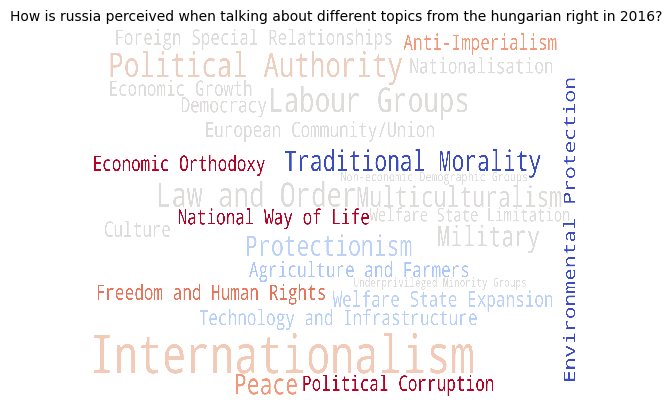

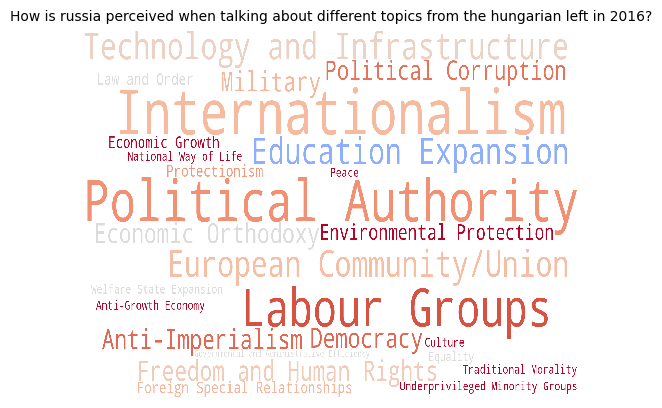

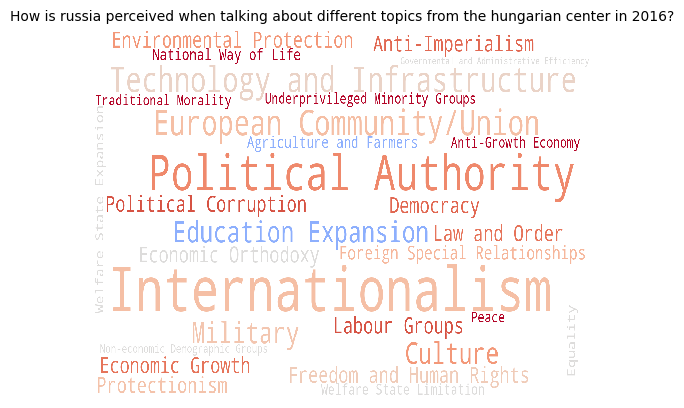

In [8]:
from wordcloud import WordCloud

year = 2016
year_end = 2021

#Filter party orientation
df_right_fr,df_cent_fr,df_left_fr= orientation_split(df_fr)

df_right_hu ,df_cent_hu,df_left_hu= orientation_split(df_hu)

generate_wordcloud(df_right_fr, f"How is russia perceived when talking about different topics from the french right in {year}?",year,year_end)
generate_wordcloud(df_left_fr, f"How is russia perceived when talking about different topics from the french left in {year}?",year,year_end)
generate_wordcloud(df_cent_fr, f"How is russia perceived when talking about different topics from the french center in {year}?",year,year_end)
generate_wordcloud(df_right_hu, f"How is russia perceived when talking about different topics from the hungarian right in {year}?",year,year_end)
generate_wordcloud(df_left_hu, f"How is russia perceived when talking about different topics from the hungarian left in {year}?",year,year_end)
generate_wordcloud(df_cent_hu, f"How is russia perceived when talking about different topics from the hungarian center in {year}?",year,year_end)


In [ ]:
for y in range(2016, 2021):
    generate_wordcloud(df_nordics, f"How is russia perceived when talking about different topics from the nordics in {y}?",year)

In [9]:
#with pl.Config(tbl_rows=-1, tbl_cols=-1):
 #   print(df_cent_fr.collect().group_by("Speaker_party_name").len()
  #  .sort("len", descending=True))

In [10]:
import re
from lxml import etree

def to_text_content(node):
    rawtxt = ''.join(node.itertext(r'{http://www.tei-c.org/ns/1.0}w', r'{http://www.tei-c.org/ns/1.0}pc'))
    return re.sub(r'\s+', ' ', rawtxt).strip()

def xml_from_text_id(text_id, texts_df):
    xmlstr = texts_df.filter(pl.col('id') == text_id)['xml'][0].decode()
    return etree.fromstring(xmlstr) # node

In [ ]:
df_texts_hu = pl.scan_parquet("../../data/texts/FR").collect()
#print(df_texts_hu.collect())
df_left_fr_2021 = df_left_fr.filter(pl.col("Date").is_between(datetime.datetime(2017, 1, 1), datetime.datetime(2021, 12, 31)))

df_left_fr_2021 = df_left_fr_2021.filter(pl.col("topics_e") == "Freedom and Human Rights")
df_sample = df_left_fr_2021.collect().sample(2)
df_sample = df_sample.with_columns(pl.col("text_id")
    .map_elements(lambda x: to_text_content(xml_from_text_id(x, df_texts_hu)), return_dtype=pl.String)
    .alias("text")
)

for row in df_sample.iter_rows(named=True):
    print(f"-----------\nTopic: {row["topics"]}, Sentiment:: {row["parsed_stance"]}\n\n{row["text"]}\n\n\n\n")
